In [1]:
!date

Mon Oct 28 02:08:26 PDT 2024


In [2]:
%env CONDA_PREFIX

'/c4/home/derek/miniconda3/envs/deepripe'

# Motifs from DeepRipe Models

In [3]:
import numpy as np
np.random.seed(1)

import os
import random
import sys
import glob
import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [4]:
import pandas as pd
import scipy as sci
import seaborn as sns
import matplotlib.pyplot as plt
import logomaker


from pathlib import Path
import json
import shutil
import h5py as h5


import pysam 
from scipy.stats import pearsonr, spearmanr


#import modified basenji modules 
sys.path.append("/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/deep_splicing")
from basenji_.basenji.dna_io import dna_1hot

import tensorflow as tf
from keras import regularizers

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
##set memory usage 

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

## get DeepRipe Model

In [6]:
model_path = '/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/deep_splicing/DeepRiPe/'

In [7]:
sys.path.append(model_path+'Scripts/')

from util_funcs import precision, recall

custom_objects={'precision':precision,
                'recall':recall,
                  }

In [8]:
model_low = tf.keras.models.load_model(model_path+'Results/PARCLIP_models/hek293/parclip_model_parclip_hek293_low_region.h5',
                                   custom_objects = custom_objects, compile=True)

In [8]:
model_mid1 = tf.keras.models.load_model(model_path+'Results/Encode_models/K562/eclip_model_encode_K562_mid1_seq.h5',
                                   custom_objects = custom_objects, compile=True)

In [9]:
model_low.outputs

[<KerasTensor: shape=(None, 27) dtype=float32 (created by layer 'output')>]

## get data

In [11]:
# for motif identifcation, use all cassette exons from MAJIQ annotation, 31713 cassette exons

In [14]:
#import modified basenji modules 
sys.path.append("/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/deep_splicing/basenji_/")

from basenji_.basenji import dataset, dataset_

from basenji_.basenji.metrics import PearsonR

In [19]:
out_dir = '/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/deep_splicing/transfer_learning//data_out/ALL_CASSETTE_PARCLIP_tfrecord/'

data_dir = [out_dir+'/fold1/']
params_file = data_dir[0]+'params.json'

In [20]:
data_dir

['/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/deep_splicing/transfer_learning//data_out/ALL_CASSETTE_PARCLIP_tfrecord//fold1/']

In [21]:
with open(params_file) as params_open:
          params = json.load(params_open)
params_model = params['model']
params_train = params['train']
os.makedirs(out_dir, exist_ok=True)
if params_file != '%s/params.json' % out_dir:
    shutil.copy(params_file, '%s/params.json' % out_dir)

In [22]:
#read datasets
train_data = []

seq_track=True


for data_dir in data_dir:
    # load train data
    train_data.append(dataset_.ExonDataset(data_dir,
        split_label='train',
        batch_size=params_train['batch_size'],
        shuffle_buffer=params_train.get('shuffle_buffer', params_model['seq_length']),
        mode='train',
        splice_track=False,
        annotation_tracks=True
                                         ))

In [23]:
onehot_data = train_data[0].numpy()[0][0][:,0,:,:]

In [24]:
onehot_region = train_data[0].numpy()[0][1][:,0,:,:]

In [26]:
from deeplift.dinuc_shuffle import dinuc_shuffle

def shuffle_several_times(s):
    s = np.squeeze(s)
    return dinuc_shuffle(s, num_shufs=100)

In [27]:
import shap
shap.explainers._deep.deep_tf.op_handlers["Split"] = shap.explainers._deep.deep_tf.passthrough

np.random.seed(1)

seqs_to_explain = onehot_data
dinuc_shuff_explainer = shap.DeepExplainer(model_low, shuffle_several_times)

/c4/home/derek/miniconda3/envs/deepripe/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/c4/home/derek/miniconda3/envs/deepripe/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


In [20]:
seqs_to_explain_subet = seqs_to_explain[:5000,600:800,:]

In [21]:
seqs_to_explain_subet.shape

(5000, 200, 4)

In [22]:
%%time
raw_shap_explanations_mid1 = dinuc_shuff_explainer.shap_values(seqs_to_explain_subet, check_additivity=False)

/c4/home/derek/miniconda3/envs/deepripe/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
CPU times: user 22min 21s, sys: 4.13 s, total: 22min 26s
Wall time: 22min 42s


In [36]:
onehot_region.shape

(2500, 1000, 4)

In [32]:
%%time
raw_shap_explanations_mid1 = dinuc_shuff_explainer.shap_values((onehot_data, onehot_region), check_additivity=False)

AssertionError: Expected a list of model inputs!

In [24]:
raw_shap_explanations_mid1_QKI = raw_shap_explanations_mid1[:,:,:,15:16]

In [25]:
pwd

'/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/deep_splicing/ExplaiNN'

In [27]:
from deeplift.visualization import viz_sequence
import logomaker

seq_len=200

# project the importance at each position onto the base that's actually present
dinuc_shuff_explanations = np.sum(raw_shap_explanations_mid1_QKI, axis=-1) * seqs_to_explain_subet
# for idx, dinuc_shuff_explanation in zip(list(range(dinuc_shuff_explanations.shape[0])), dinuc_shuff_explanations):
    
#     print("Scores for example", idx)

        
#     logo = logomaker.Logo(pd.DataFrame(dinuc_shuff_explanation[0:seq_len,:], columns=['A', 'C', 'G', 'U']),
#                                       shade_below=.5,
#                                     fade_below=.5,
#                                     # font_name='Arial Rounded MT Bold',
#                                    show_spines=False,
#                                     figsize=(60, 1),
#                   )
#     plt.vlines(x=(0,200), ymin= logo.ax.get_ylim()[0], ymax= logo.ax.get_ylim()[1] )
    
#     plt.show()

In [28]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

## TF-MoDisco motif clustering

In [29]:
RBP='QKI'

In [30]:
if not os.path.exists('./eval'):
    os.makedirs('./eval')
    
if not os.path.exists(f'./eval/modisco_outs_{RBP}'):
    os.makedirs(f'./eval/modisco_outs_{RBP}')
    
modisco_outs = f'./eval/modisco_outs_{RBP}/'

In [31]:
seqs_to_explain_subet.shape

(5000, 200, 4)

In [32]:
dinuc_shuff_explanations.shape

(5000, 200, 4)

In [33]:
np.save(modisco_outs+'ohe.npy', seqs_to_explain_subet.transpose(0, 2, 1))

np.save(modisco_outs+'ig.npy', dinuc_shuff_explanations.transpose(0, 2, 1))

In [34]:
# !modisco motifs  -h

In [35]:
# !modisco report -h

In [36]:
RBP

'QKI'

In [37]:
%%bash -s {RBP}

RBP=$1



modisco motifs -s ./eval/modisco_outs_${RBP}/ohe.npy \
                -a ./eval/modisco_outs_${RBP}/ig.npy \
                -n 2000 \
                -w 200 \
                -o ./eval/modisco_outs_${RBP}/modisco_results.h5 \

In [40]:
# import sys
# !mamba install -c bioconda --yes --prefix {sys.prefix} meme


Looking for: ['meme']

[+] 0.0s
[+] 0.1s
bioconda/linux-64 (check zst) ━━━━━━━━━━━━━━━   0.0 B @  ??.?MB/s Checking  0.1s[+] 0.2s
bioconda/linux-64 (check zst) ━━━━━━━━━━━━━━━   0.0 B @  ??.?MB/s Checking  0.2s[+] 0.3s
bioconda/linux-64 (check zst) ━━━━━━━━━━━━━━━   0.0 B @  ??.?MB/s Checking  0.3sbioconda/linux-64 (check zst)                       Checked  0.4s
[+] 0.0s
bioconda/noarch (check zst)                        Checked  0.0s
[+] 0.0s
pkgs/main/linux-64 (check zst) ━━━━╸━━━━━━━━━━━━━━━╸━━━━━   0.0 B Checking  0.0spkgs/main/linux-64 (check zst)                      Checked  0.1s
[+] 0.0s
pkgs/main/noarch (check zst)                       Checked  0.0s
[+] 0.0s
pkgs/r/linux-64 (check zst) ╸━━━━━━━━━━━━━━━━   0.0 B @  ??.?MB/s Checking  0.0spkgs/r/linux-64 (check zst)                         Checked  0.0s
[+] 0.0s
pkgs/r/noarch (check zst) ━━━━━━╸━━━━━━━━━━━━   0.0 B @  ??.?MB/s Checking  0.0spkgs/r/noarch (check zst)                           Checked  0.0s
[+] 0.0s
bcbio/linux-

In [41]:
%%bash -s {RBP}

RBP=$1

modisco report -i ./eval/modisco_outs_${RBP}/modisco_results.h5 \
               -o ./eval/modisco_outs_${RBP}/modisco_report/ \
               -s ./eval/modisco_outs_${RBP}/modisco_report/ \
               -m /c4/home/derek/bin/concise/concise/resources/attract_pwm.txt

FATAL: Motif file '/c4/home/derek/bin/concise/concise/resources/attract_pwm.txt' uses a 'undefined' alphabet when a 'DNA' alphabet was expected.

Traceback (most recent call last):
  File "/c4/home/derek/miniconda3/envs/deepripe/bin/modisco", line 215, in <module>
    modiscolite.report.report_motifs(args.h5py, args.output,
  File "/c4/home/derek/miniconda3/envs/deepripe/lib/python3.10/site-packages/modiscolite/report.py", line 285, in report_motifs
    tomtom_df = generate_tomtom_dataframe(modisco_h5py, output_dir, meme_motif_db,
  File "/c4/home/derek/miniconda3/envs/deepripe/lib/python3.10/site-packages/modiscolite/report.py", line 157, in generate_tomtom_dataframe
    r = fetch_tomtom_matches(ppm, cwm,
  File "/c4/home/derek/miniconda3/envs/deepripe/lib/python3.10/site-packages/modiscolite/report.py", line 116, in fetch_tomtom_matches
    tomtom_results = pandas.read_csv(tomtom_fname, sep="\t", usecols=(1, 5))
  File "/c4/home/derek/miniconda3/envs/deepripe/lib/python3.10/site-pack

CalledProcessError: Command 'b'\nRBP=$1\n\nmodisco report -i ./eval/modisco_outs_${RBP}/modisco_results.h5 \\\n               -o ./eval/modisco_outs_${RBP}/modisco_report/ \\\n               -s ./eval/modisco_outs_${RBP}/modisco_report/ \\\n               -m /c4/home/derek/bin/concise/concise/resources/attract_pwm.txt\n'' returned non-zero exit status 1.

## Plotting Motifs

In [158]:
RBP = 'QKI'

In [128]:
!modisco meme --help


usage: modisco meme [-h] [-i H5PY] -t {PFM,CWM,hCWM,CWM-PFM,hCWM-PFM}
                    [-o OUTPUT] [-q]

options:
  -h, --help            show this help message and exit
  -i H5PY, --h5py H5PY  An HDF5 file containing the output from modiscolite.
  -t {PFM,CWM,hCWM,CWM-PFM,hCWM-PFM}, --datatype {PFM,CWM,hCWM,CWM-PFM,hCWM-PFM}
                        A case-sensitive string specifying the desired data of the output file.,
                        The options are as follows:
                        - 'PFM':      The position-frequency matrix.
                        - 'CWM':      The contribution-weight matrix.
                        - 'hCWM':     The hypothetical contribution-weight matrix; hypothetical
                                      contribution scores are the contributions of nucleotides not encoded
                                      by the one-hot encoding sequence. 
                        - 'CWM-PFM':  The softmax of the contribution-weight matrix.
                    

In [159]:
%%bash -s {RBP}

RBP=$1

modisco meme -i ./eval/modisco_outs_${RBP}/modisco_results.h5 \
            -t 'CWM' \
            -o ./eval/modisco_outs_${RBP}/modisco_report/meme_${RBP}_CWM \
            -q

In [162]:
RBP = 'PTBP1'

In [164]:
#RBFOX2

#QKI: skiprows=42, nrows=30
#PTBP1: skiprows=9, nrows=30,


PWM = pd.read_csv(f'./eval/modisco_outs_{RBP}/modisco_report/meme_{RBP}_CWM', skiprows=9, nrows=30, sep =' ', header=None)

PWM.columns = ['A', 'C', 'G', 'U']

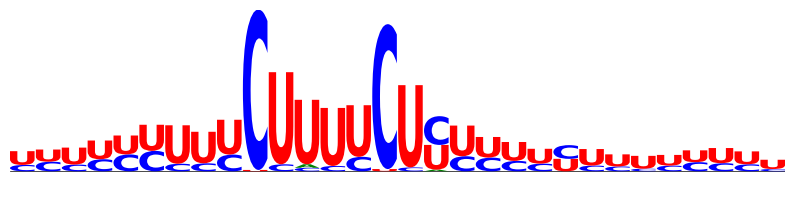

In [166]:
fig, ax = plt.subplots(figsize = (10,2.5))

logomaker.Logo(PWM,#.iloc[8:16],
              show_spines=False,
              fade_below=1.0, 
              ax=ax)

ax.set_xticks([])
ax.set_yticks([])

fig.savefig('PTBP1_top_modisco.pdf')

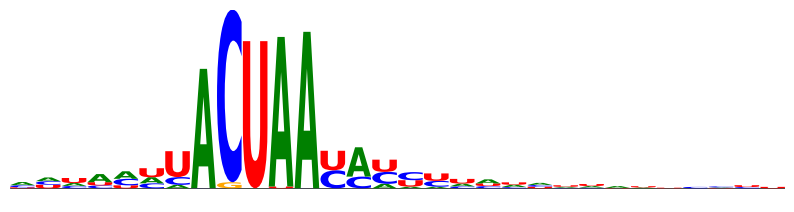

In [161]:
fig, ax = plt.subplots(figsize = (10,2.5))

logomaker.Logo(PWM,#.iloc[8:16],
              show_spines=False,
              fade_below=1.0, 
              ax=ax)

ax.set_xticks([])
ax.set_yticks([])

fig.savefig('QKI_top_modisco.pdf')

[]

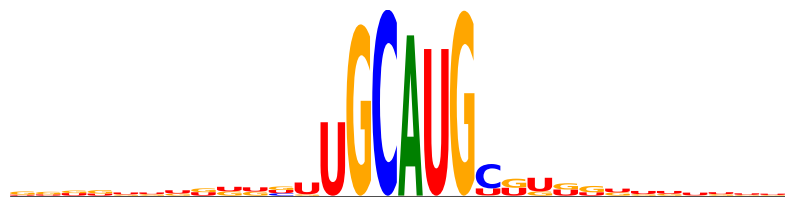

In [124]:
fig, ax = plt.subplots(figsize = (10,2.5))
logomaker.Logo(PWM,#.iloc[8:16],
              show_spines=False,
              fade_below=1.0, 
              ax=ax)



ax.set_xticks([])
ax.set_yticks([])

#fig.savefig